In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from livelossplot.tf_keras import PlotLossesCallback
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


import pickle

import numpy as np
import pandas as pd
from datetime import datetime 
import multiprocessing
import re
from bs4 import BeautifulSoup as bs
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency

import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

import matplotlib.pyplot as plt

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings("ignore") #, category=np.VisibleDeprecationWarning)

print(tf.__version__)

2.12.0


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.01):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), 
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [4]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Preprocessing function

In [5]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
    text = bs(text,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    text = re.sub("[^a-zA-Z]"," ", text)
    
    # 3. Converting to lower case and splitting
    word_tokens = text.lower().split()
    
    # 4. Remove stopwords
    le = WordNetLemmatizer()
    stop_words = set(stopwords.words("english")+ ['14000kbps', 'november', '1080p', 'email', 
                                                 '4k', 'mp4', 'error', '404', '2022'])     
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review = " ".join(word_tokens)
    return cleaned_review

In [6]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [7]:
df_pos = pd.read_csv('../datasets/BadWordsService_ml_has_7days.csv')
df_neg =  pd.read_csv('../datasets/BadWordsService_ml_has_no_7days.csv')
df_val = pd.read_csv('../datasets/BadWordsService_ml_has_today.csv')

In [8]:
df_pos.drop('@timestamp', axis=1, inplace=True)
df_neg.drop('@timestamp', axis=1, inplace=True)
df_val.drop('@timestamp', axis=1, inplace=True)
df_val['ctxt_.time_spent'] = df_val['ctxt_.time_spent'] * 1000 # convert seconds to milliseconds

In [9]:
df_pos.rename(columns={"ctxt_.text": "raw_text", "ctxt_.time_spent": "time_spent_ms"}, inplace=True)
df_neg.rename(columns={"ctxt_.text": "raw_text", "ctxt_.time_spent": "time_spent_ms"}, inplace=True)
df_val.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
df_val.rename(columns={"ctxt_.time_spent": "time_spent_ms"}, inplace=True)

In [10]:
df_pos.head()

,time_spent_ms,raw_text
0,0.1,<p>A sexy gagged waitress is brought in the ro...
1,0.0,"DID, ASS GRABBING, GROPING DAMSEL IN DISTRESS"
2,0.0,"KICKING, CBT, AMATEUR, HIGH HEELS BALL ABUSE"
3,0.6,start\tend\ttext\n280\t260\tThere's another on...
4,0.5,"<p><img src=""http://www.astrodomina.com/mdm/im..."


In [11]:
df_neg.head()

,time_spent_ms,raw_text
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...
2,0.1,Wicked Chicks Show To Their Little Servant How...
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI..."
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ..."


In [12]:
df_val.head()

,time_spent_ms,raw_text
0,200.0,<p>I love these spiked platform heels SO much!...
1,1100.0,start\tend\ttext\n180000\t205060\tThe\n205060\...
2,100.0,<p>Lots of implements to use to this white sla...
3,600.0,start\tend\ttext\n0\t28960\tHope you enjoyed t...
4,200.0,<p>Complete strapon clip</p>\r\n<p>Part 1</p>\...


In [13]:
df_pos['labels'] = 1
df_neg['labels'] = 0

In [14]:
df_pos.head()

,time_spent_ms,raw_text,labels
0,0.1,<p>A sexy gagged waitress is brought in the ro...,1
1,0.0,"DID, ASS GRABBING, GROPING DAMSEL IN DISTRESS",1
2,0.0,"KICKING, CBT, AMATEUR, HIGH HEELS BALL ABUSE",1
3,0.6,start\tend\ttext\n280\t260\tThere's another on...,1
4,0.5,"<p><img src=""http://www.astrodomina.com/mdm/im...",1


In [15]:
df_neg.head()

,time_spent_ms,raw_text,labels
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...,0
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...,0
2,0.1,Wicked Chicks Show To Their Little Servant How...,0
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI...",0
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ...",0


In [16]:
df_val.head()

,time_spent_ms,raw_text
0,200.0,<p>I love these spiked platform heels SO much!...
1,1100.0,start\tend\ttext\n180000\t205060\tThe\n205060\...
2,100.0,<p>Lots of implements to use to this white sla...
3,600.0,start\tend\ttext\n0\t28960\tHope you enjoyed t...
4,200.0,<p>Complete strapon clip</p>\r\n<p>Part 1</p>\...


In [17]:
nan_values_neg = df_neg[df_neg.isna().any(axis=1)]
print(len(nan_values_neg))

# nan_values_pos = df_pos[df_pos.isna().any(axis=1)]
# print(len(nan_values_pos))

nan_values = df_val[df_val.isna().any(axis=1)]
print(len(nan_values))

221
0


In [18]:
df_neg.dropna(inplace=True)
df_neg.head()

,time_spent_ms,raw_text,labels
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...,0
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...,0
2,0.1,Wicked Chicks Show To Their Little Servant How...,0
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI...",0
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ...",0


In [19]:
df_pos['text'] = df_pos.apply(lambda row: clean_text(row.raw_text), axis=1)
df_neg['text'] = df_neg.apply(lambda row: clean_text(row.raw_text), axis=1)
df_val['text'] = df_val.apply(lambda row: clean_text(row.raw_text), axis=1)

In [20]:
df_pos.head()

,time_spent_ms,raw_text,labels,text
0,0.1,<p>A sexy gagged waitress is brought in the ro...,1,sexy gagged waitress brought room masked man s...
1,0.0,"DID, ASS GRABBING, GROPING DAMSEL IN DISTRESS",1,as grabbing groping damsel distress
2,0.0,"KICKING, CBT, AMATEUR, HIGH HEELS BALL ABUSE",1,kicking cbt amateur high heel ball abuse
3,0.6,start\tend\ttext\n280\t260\tThere's another on...,1,start end text another one erotic took side ri...
4,0.5,"<p><img src=""http://www.astrodomina.com/mdm/im...",1,hd x p step mom help homework boner pant hangi...


In [21]:
df_neg.head()

,time_spent_ms,raw_text,labels,text
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...,0,wicked chick show little servant worship tasty...
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...,0,wicked chick show little servant worship tasty...
2,0.1,Wicked Chicks Show To Their Little Servant How...,0,wicked chick show little servant worship tasty...
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI...",0,as humiliation double domination as sniffing t...
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ...",0,nevada max beautiful expressive eye going look...


In [22]:
df_val.head()

,time_spent_ms,raw_text,text
0,200.0,<p>I love these spiked platform heels SO much!...,love spiked platform heel much dangerous sexy ...
1,1100.0,start\tend\ttext\n180000\t205060\tThe\n205060\...,start end text squirrel ah ah mm woah woah oh ...
2,100.0,<p>Lots of implements to use to this white sla...,lot implement use white slave butt miss courtn...
3,600.0,start\tend\ttext\n0\t28960\tHope you enjoyed t...,start end text hope enjoyed new video see show...
4,200.0,<p>Complete strapon clip</p>\r\n<p>Part 1</p>\...,complete strapon clip part man go see therapis...


In [23]:
df_pos.drop('raw_text', axis=1, inplace=True)
df_neg.drop('raw_text', axis=1, inplace=True)
df_val.drop('raw_text', axis=1, inplace=True)

In [24]:
df_pos.shape, df_neg.shape, df_val.shape

((7746, 3), (31812, 3), (2175, 2))

In [25]:
df_tra = pd.concat([df_pos, df_neg], ignore_index=True)
df_tra.shape

(39558, 3)

In [26]:
df_tra.head()

,time_spent_ms,labels,text
0,0.1,1,sexy gagged waitress brought room masked man s...
1,0.0,1,as grabbing groping damsel distress
2,0.0,1,kicking cbt amateur high heel ball abuse
3,0.6,1,start end text another one erotic took side ri...
4,0.5,1,hd x p step mom help homework boner pant hangi...


In [27]:
df_val.head()

,time_spent_ms,text
0,200.0,love spiked platform heel much dangerous sexy ...
1,1100.0,start end text squirrel ah ah mm woah woah oh ...
2,100.0,lot implement use white slave butt miss courtn...
3,600.0,start end text hope enjoyed new video see show...
4,200.0,complete strapon clip part man go see therapis...


In [28]:
counter = counter_word(df_tra.text)  

In [29]:
vocab_size = len(counter)
oov_token = '<UNK>'

maxlen = 200  # Only consider the first 200 words of each movie review

In [30]:
counter

Counter({'sexy': 3084,
         'gagged': 1027,
         'waitress': 10,
         'brought': 239,
         'room': 1201,
         'masked': 68,
         'man': 1884,
         'sits': 307,
         'forcefully': 26,
         'straddle': 46,
         'couch': 399,
         'wrist': 224,
         'tied': 1360,
         'behind': 677,
         'back': 4841,
         'squeeze': 366,
         'hell': 250,
         'as': 11175,
         'thigh': 933,
         'toss': 52,
         'side': 1013,
         'tie': 669,
         'ankle': 530,
         'together': 790,
         'really': 4008,
         'manhandles': 3,
         'grope': 51,
         'shannon': 1,
         'helpless': 473,
         'struggling': 579,
         'grabbing': 233,
         'groping': 188,
         'damsel': 219,
         'distress': 156,
         'kicking': 484,
         'cbt': 947,
         'amateur': 463,
         'high': 2038,
         'heel': 2107,
         'ball': 3040,
         'abuse': 524,
         'start': 4775,


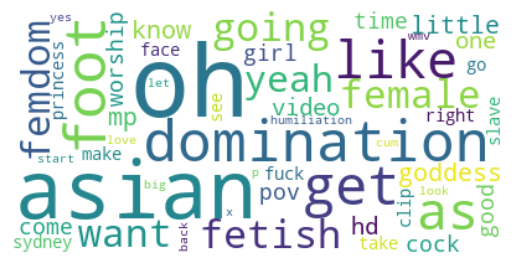

In [31]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [59]:
from sklearn.utils import shuffle
RANDOM_STATE = 42

df_tra = shuffle(df_tra, random_state=RANDOM_STATE).reset_index(drop=True)

train_size = int(df_tra.shape[0] * .8)

train = df_tra[:train_size]
val = df_tra[train_size:]

# Split train and test

X_train = train.text.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text.to_numpy()
y_val = val.labels.to_numpy()

In [60]:
print(len(X_train), "Training sequences")
print(len(X_val), "Validation sequences")

31646 Training sequences
7912 Validation sequences


In [61]:
y_val[:5]

array([1, 0, 0, 0, 1])

In [62]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer = Tokenizer(num_words=vocab_size) #, oov_token=oov_token)
tokenizer.fit_on_texts(df_tra.text.to_numpy())

# # saving
# with open('../models/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
# with open('../models/tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [63]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=maxlen)
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_sequences, maxlen=maxlen)

# Build Model

In [64]:
embed_dim = 32  # Embedding size for each token 32
num_heads = 2  # Number of attention heads default value 2
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
X = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
X = transformer_block(X)
X = GlobalAveragePooling1D()(X)
X = Dropout(0.1)(X) #.1
X = Dense(20, activation="relu")(X)
X = Dropout(0.1)(X) # .1
outputs = Dense(1, activation='sigmoid')(X)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          857024    
 g_1 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_1 (Transf  (None, 200, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_6 (Dropout)         (None, 32)                0   

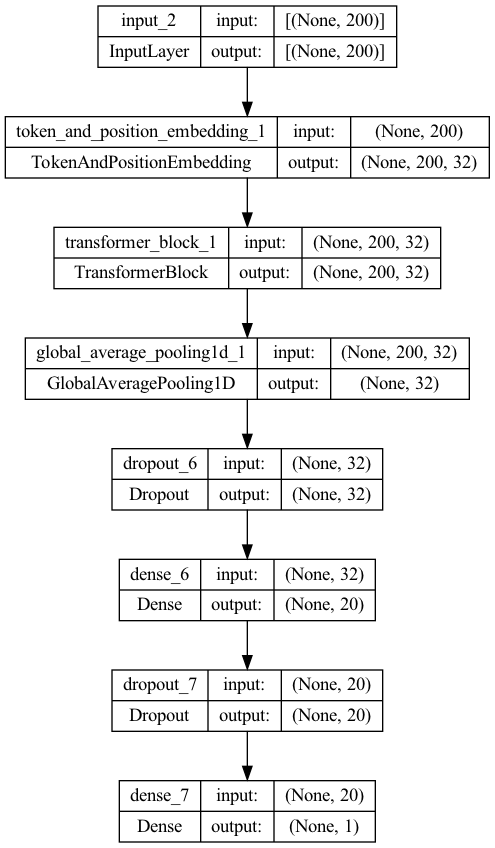

In [65]:
# draw model
tf.keras.utils.plot_model(model, show_shapes=True)

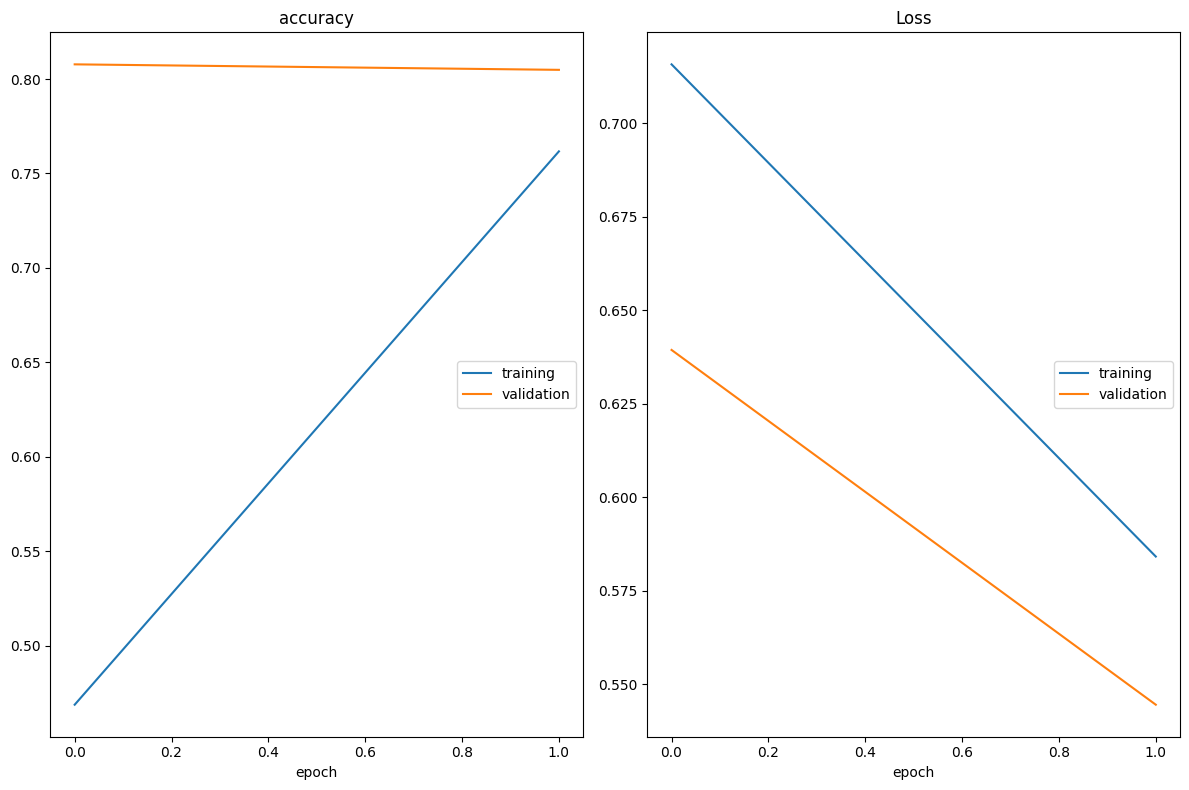

accuracy
	training         	 (min:    0.469, max:    0.762, cur:    0.762)
	validation       	 (min:    0.805, max:    0.808, cur:    0.805)
Loss
	training         	 (min:    0.584, max:    0.716, cur:    0.584)
	validation       	 (min:    0.545, max:    0.639, cur:    0.545)
989/989 [==============================] - 105s 106ms/step - loss: 0.5841 - accuracy: 0.7617 - val_loss: 0.5445 - val_accuracy: 0.8049


In [66]:
lr = .000001 #1e-5
epochs = 2

loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=lr) #.000001)
metrics = ['accuracy']

# metrics = [tf.keras.metrics.BinaryAccuracy(),
#            tf.keras.metrics.FalseNegatives(),
#            tf.keras.metrics.FalsePositives(),
#           ]

from pathlib import Path

path = Path('../models/bad_words/trans/')
path.mkdir(exist_ok=True) 
cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=2, 
                                                save_best_only=True, mode='min')

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=32, validation_data=(X_val_padded, y_val), verbose=1, 
           callbacks=[checkpoint, PlotLossesCallback()])
          
# history = model.fit(X_train_padded, y_train, 
#                     batch_size=64, epochs=10, 
#                     validation_data=(X_val_padded, y_val)
#                    )

In [67]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.715712,0.468874,0.639358,0.807760
1,0.584126,0.761708,0.544514,0.804853


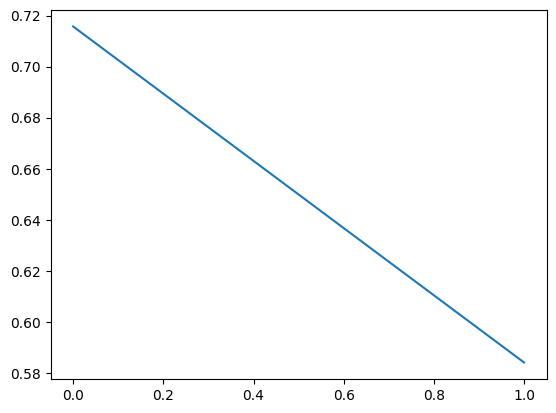

In [68]:
plt.plot(history_df.loss);

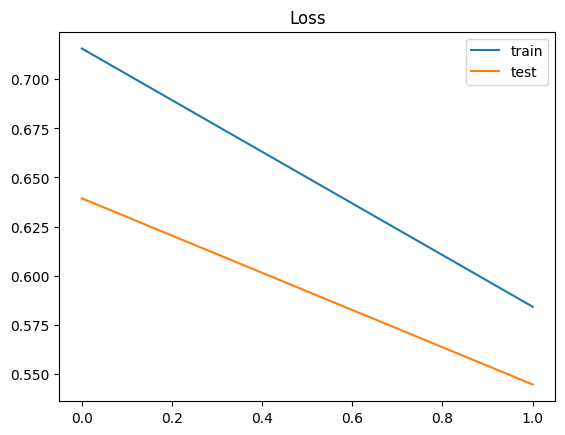

In [69]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

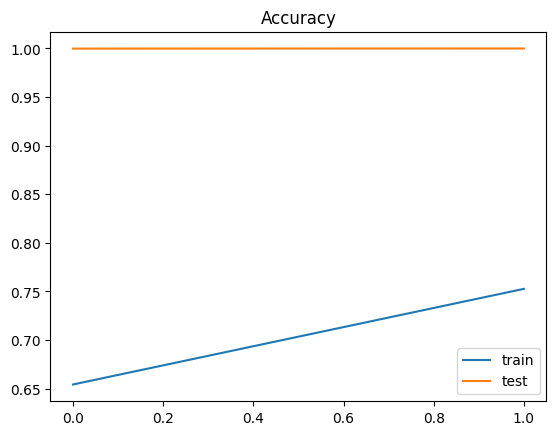

In [43]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [44]:
results = model.evaluate(X_val_padded, y_val, verbose=2)

for name, value in zip(model.metrics_names, results):
    print("%s: %.3f" % (name, value))

248/248 - 11s - loss: 0.2747 - accuracy: 0.9999 - 11s/epoch - 44ms/step
loss: 0.275
accuracy: 1.000


In [45]:
predictions = model.predict(X_train_padded[1100:1120])
predictions = [1 if p > .5 else 0 for p in predictions]
predictions

1/1 [==============================] - 0s 498ms/step


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [46]:
def roc_auc(predictions, target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [47]:
print(X_train[1010:1011])
print(X_train_sequences[1010:1011])
print(X_train_padded[1010:1011])

['face assault part ii wmv']
[[30, 2573, 81, 1134, 48]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0  

In [48]:
# model.save_weights("../models/bpredict_class_weights.h5")
# model.load_weights("../models/bpredict_class_weights.h5") # loading weights - model had created erlier

In [49]:
# model = tf.keras.models.load_model("../models/bpredict_class_model.h5"))
# model.trainable = False # замораживаем базовую модель

In [50]:
######## new
import itertools as itt
chunksize = 200
    
# vectorize a text corpus by turning each text into sentence of integers
max_len = 200
# tokenizer = Tokenizer(num_words=num_unique_words, oov_token=oov_token)
# tokenizer.fit_on_texts(X)


values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(df_val.text):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    tf.config.run_functions_eagerly(True)
    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
########
# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

1/1 [==============================] - 0s 67ms/step


1/1 [==============================] - 0s 118ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 64ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 78ms/step


In [51]:
# del(df_result)
df_result.head()

,text,time_elapsed_ms,label
0,love spiked platform heel much dangerous sexy ...,398.2,0
1,start end text squirrel ah ah mm woah woah oh ...,297.8,0
2,lot implement use white slave butt miss courtn...,165.4,0
3,start end text hope enjoyed new video see show...,157.0,0
4,complete strapon clip part man go see therapis...,157.2,0


In [52]:
df_val.head()

,time_spent_ms,text
0,200.0,love spiked platform heel much dangerous sexy ...
1,1100.0,start end text squirrel ah ah mm woah woah oh ...
2,100.0,lot implement use white slave butt miss courtn...
3,600.0,start end text hope enjoyed new video see show...
4,200.0,complete strapon clip part man go see therapis...


In [53]:
df_result.head()

,text,time_elapsed_ms,label
0,love spiked platform heel much dangerous sexy ...,398.2,0
1,start end text squirrel ah ah mm woah woah oh ...,297.8,0
2,lot implement use white slave butt miss courtn...,165.4,0
3,start end text hope enjoyed new video see show...,157.0,0
4,complete strapon clip part man go see therapis...,157.2,0


In [54]:
df_united = df_val.merge(df_result, right_on='text', left_on='text')
df_united['time_delta'] = df_united.time_spent_ms - df_united.time_elapsed_ms
df_united = df_united[['text', 'time_spent_ms', 'time_elapsed_ms', 'time_delta', 'label']]
df_united.drop_duplicates(['text'], keep='last', ignore_index=True, inplace=True)

In [55]:
df_united.head(20)

,text,time_spent_ms,time_elapsed_ms,time_delta,label
0,love spiked platform heel much dangerous sexy ...,200.0,398.2,-198.2,0
1,start end text squirrel ah ah mm woah woah oh ...,1100.0,297.8,802.2,0
2,lot implement use white slave butt miss courtn...,100.0,165.4,-65.4,0
3,start end text hope enjoyed new video see show...,600.0,157.0,443.0,0
4,complete strapon clip part man go see therapis...,200.0,157.2,42.8,0
5,female domination pegging mesmerize femdom hum...,100.0,422.2,-322.2,0
6,twitter custom clip request big bos hire young...,1500.0,327.2,1172.8,0
7,nymphomaniac forced submission wmv,100.0,147.6,-47.6,0
8,despressi killer heel oh yes totally love hot ...,200.0,198.6,1.4,0
9,introducing india beautiful petite ebony brat ...,300.0,315.2,-15.2,0


In [56]:
# df_united.to_csv('../datasets/trans_pred_.csv')

In [72]:
######## new
import itertools as itt
chunksize = 200
max_len = chunksize

# raw_text = "After a morning of horse-back riding, Sara Domina returns home with her boots dirtied, the soles soiled with .....Her slave is in waiting, unawares of what is about to happen to him ....."
raw_text = """nymphomaniac forced submission wmv"""
# raw_text = """ROPE BONDAGE, BALLGAGGED, SUSPENSION, BAREFOOT, STRUGGLING     Astrid, Vidana, clip by John, no nudity, ballgag, tight hogtie, toe tied, hogtied suspended, turntable bondage device, rope tied girls, strict hogtie, young girls next door, double bondage, jute and white ropes, smaller file"""
test_text_preprocessed = [clean_text(raw_text)]
print(test_text_preprocessed)
values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(test_text_preprocessed):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
df_result

['nymphomaniac forced submission wmv']
1/1 [==============================] - 0s 28ms/step


,text,time_elapsed_ms,label
0,nymphomaniac forced submission wmv,145.6,0


In [58]:
# def decode(sequence):
#     return " ".join([rvi.get(idx, "?") for idx in sequence])

# decoded_text = decode(X_train_sequences[10])

# print(X_train_sequences[10])
# print(decoded_text)